<a href="https://colab.research.google.com/github/hadwin-357/GCN/blob/main/Node_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
os.environ['TORCH']= torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 26.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [34]:
#helper function for visualization
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph (G, color):
  plt.figure(figsize=(7,7))
  nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
    node_color = color, cmap ='Set2')
  plt.show()

def visualize_embedding(h, color, epoch=None, loss=None):
  plt.figure(figsize=(7,7))
  h=h.detach().cpu().numpy()
  plt.scatter(h[:,0], h[:,1], s=140, c= color, cmap='Set2')
  if epoch is not None and loss is not None:
    plt.xlabel(f'Ephoch:{epoch}, Loss: {loss.item():4f}', fontsize=16)
  plt.show()


In [4]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset:{dataset}')
print(f'Number of graph:{len(dataset)}')
print(f'Number of features:{dataset.num_features}') # dimension of feature vector
print(f'Number of classese: {dataset.num_classes}') # classes each node belongs to

Dataset:KarateClub()
Number of graph:1
Number of features:34
Number of classese: 4


In [7]:
data = dataset[0] #get the first graph

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes: 2f}')
print(f'Number of training nodes:{data.train_mask.sum()}')
print(f'Has isolated nodes:{data.has_isolated_nodes}')
print(f'Has self_loops:{data.has_self_loops}')
print(f'Is undirected:{data.is_undirected}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree:  4.588235
Number of training nodes:4
Has isolated nodes:<bound method BaseData.has_isolated_nodes of Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])>
Has self_loops:<bound method BaseData.has_self_loops of Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])>
Is undirected:<bound method BaseData.is_undirected of Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])>


In [12]:
from IPython.display import Javascript # Restrict height of output cell
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
edge_index = data.edge_index
print (edge_index)

<IPython.core.display.Javascript object>

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

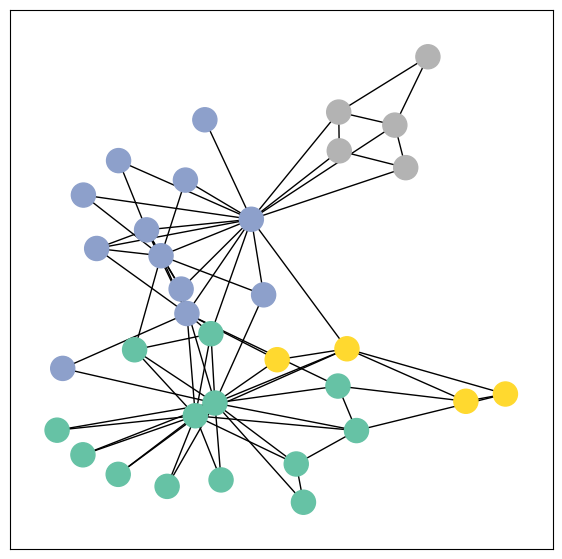

In [16]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [32]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(42)
    self.conv1=GCNConv(dataset.num_features, 4)
    self.conv2=GCNConv(4, 4)
    self.conv3=GCNConv(4, 2)
    self.classifier = Linear(2, dataset.num_classes)

  def forward (self, x, edge_index):
    h = self.conv1(x, edge_index)
    h = h.tanh()
    h = self.conv2(h,edge_index)
    h = h.tanh()
    h = self.conv3(h,edge_index)
    h = h.tanh()

    # apply a final classifier
    out = self.classifier(h)

    return out , h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Eemedding shape: [34, 2]


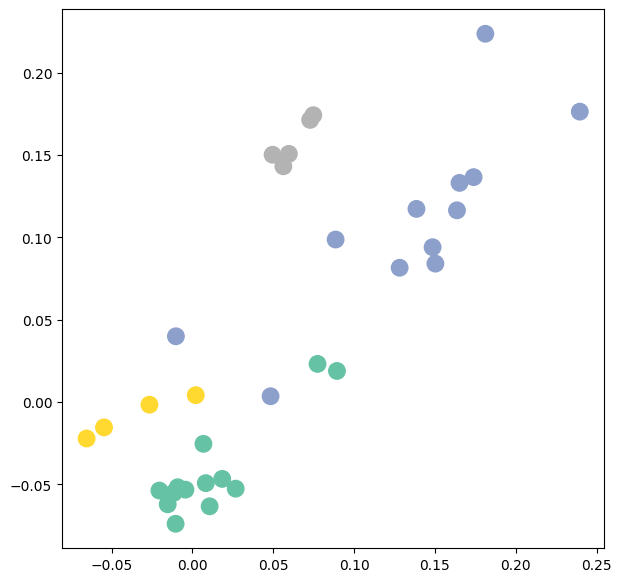

In [35]:
_, h = model(data.x, data.edge_index )
print(f'Eemedding shape: {list(h.shape)}')

visualize_embedding(h, color = data.y)

  0%|          | 0/401 [00:00<?, ?it/s]

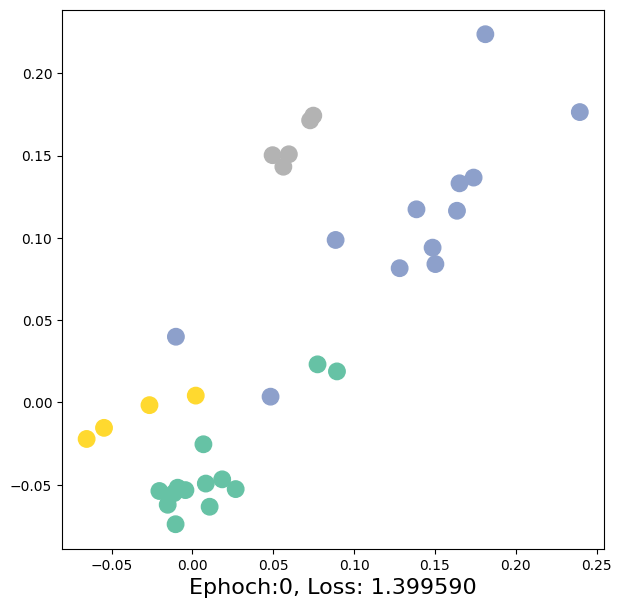

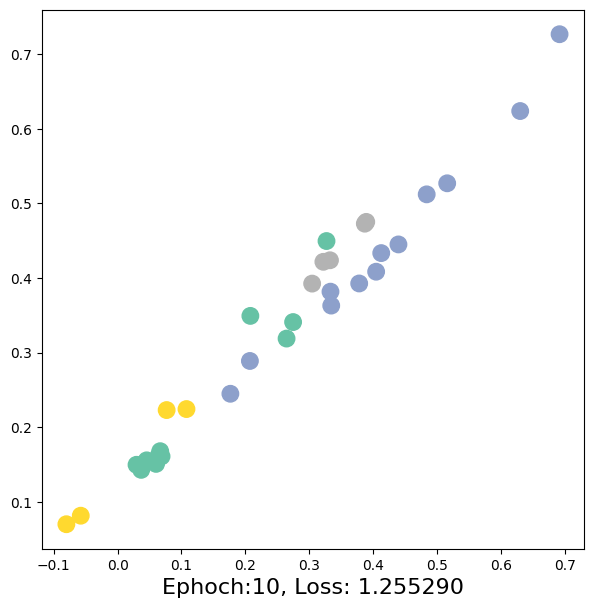

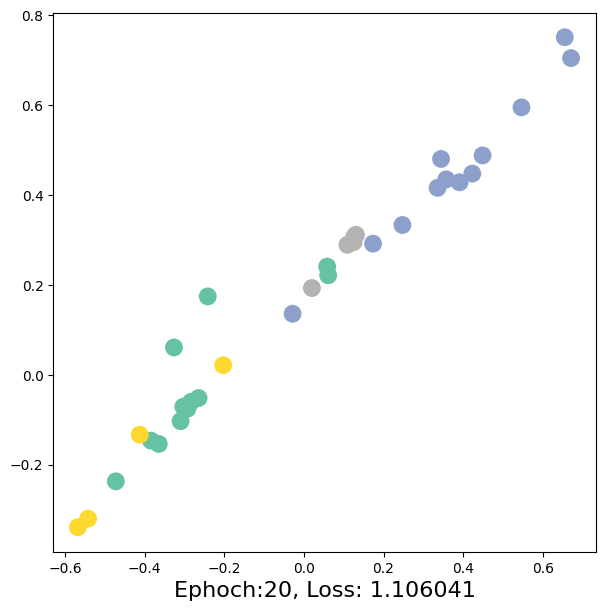

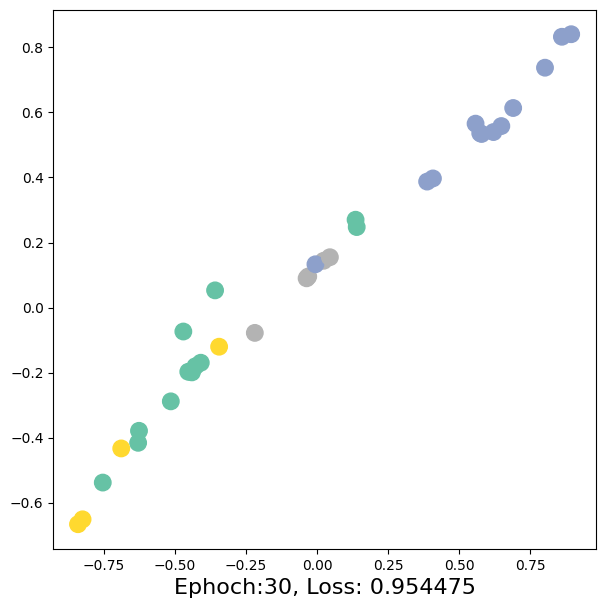

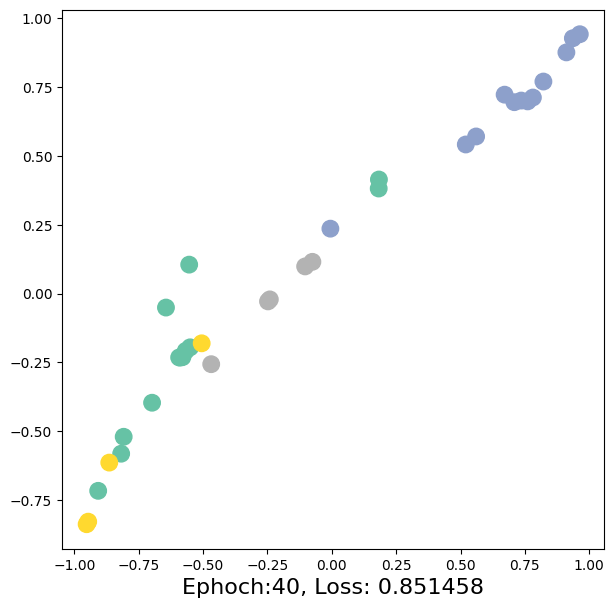

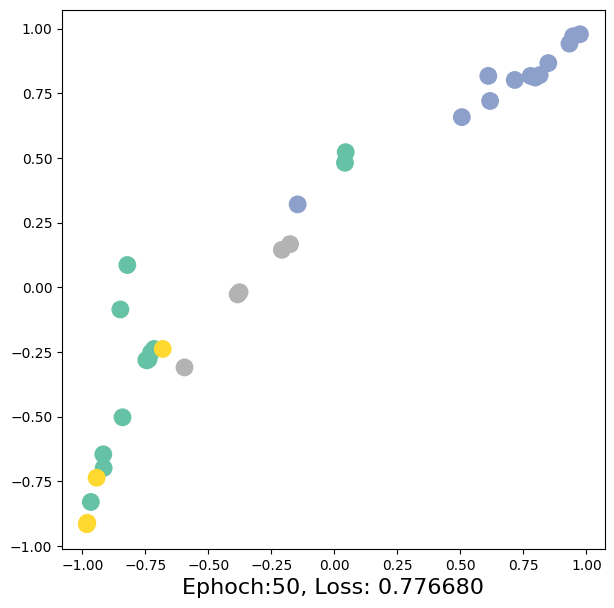

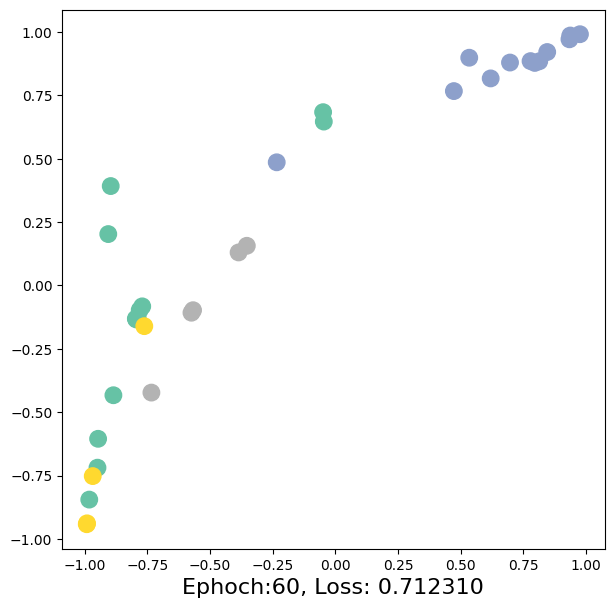

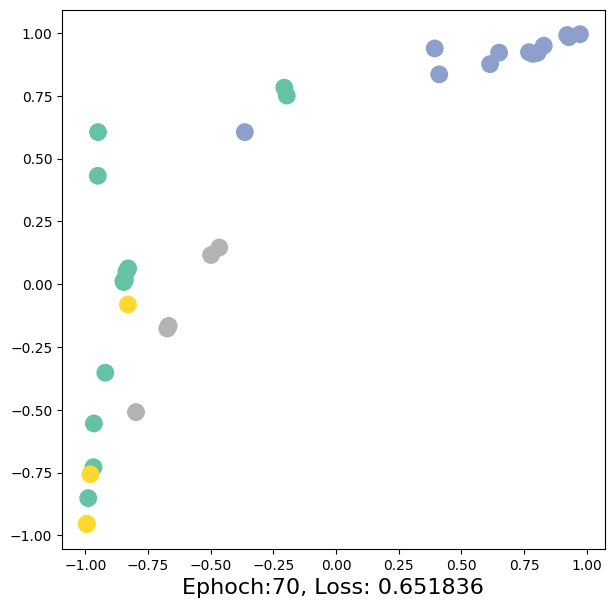

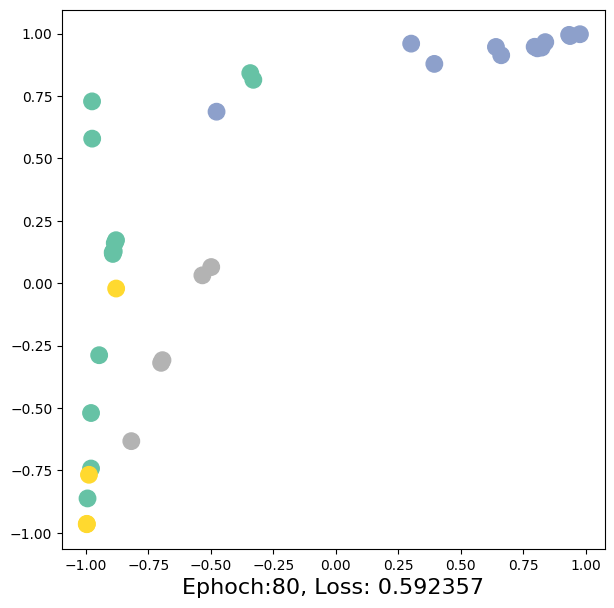

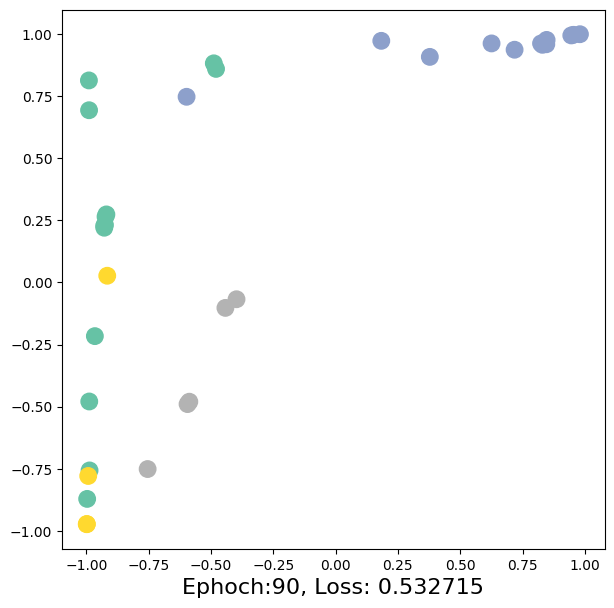

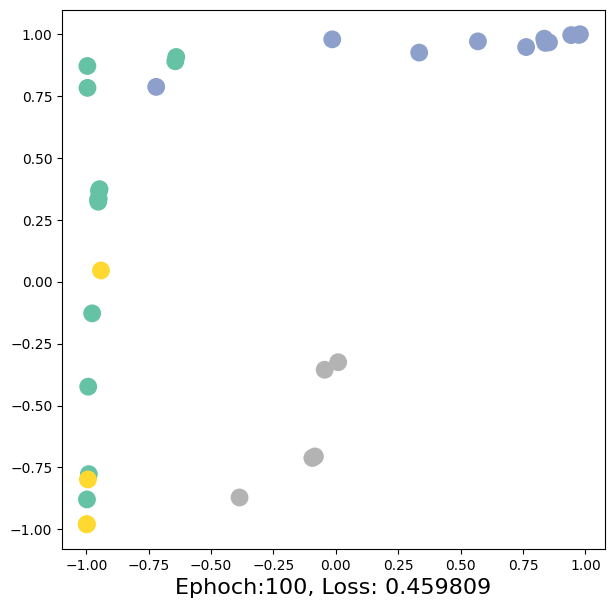

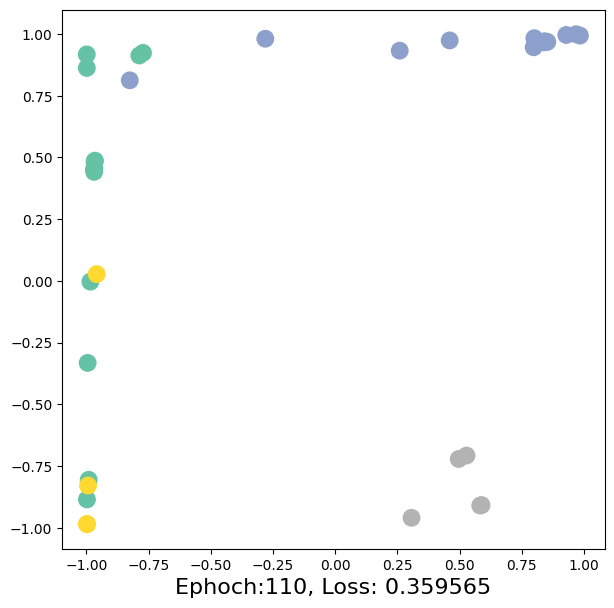

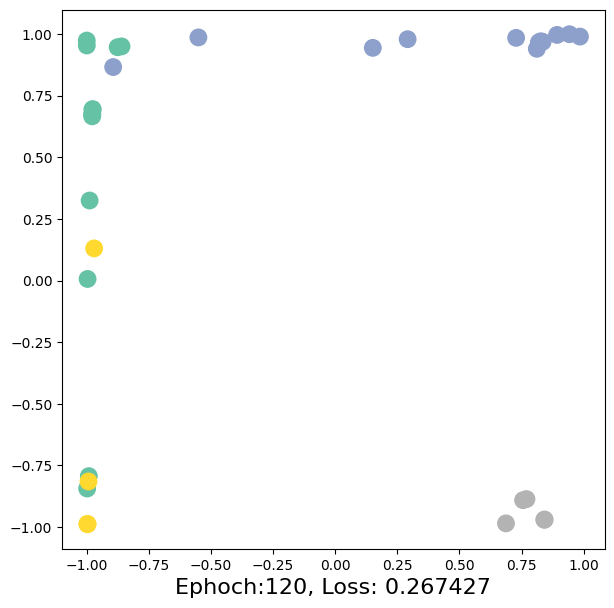

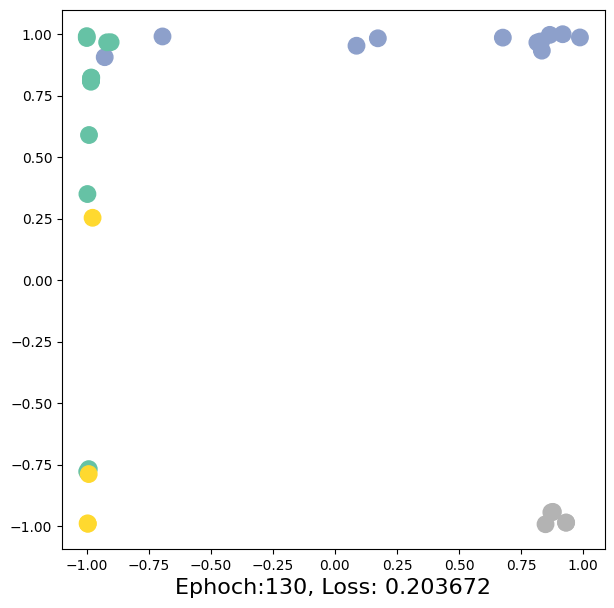

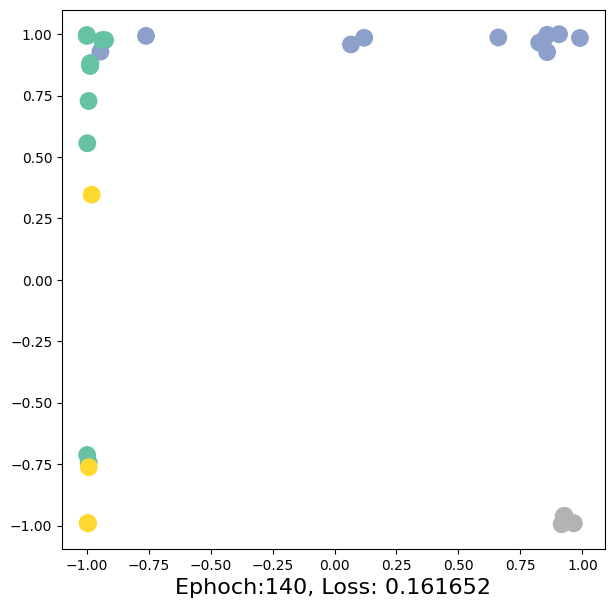

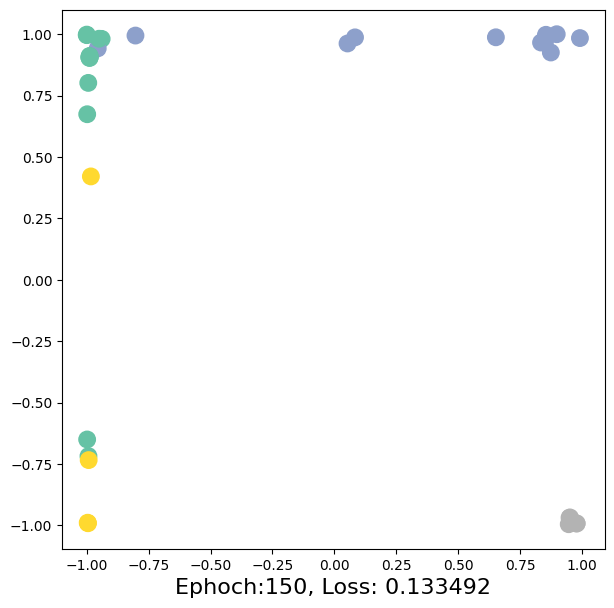

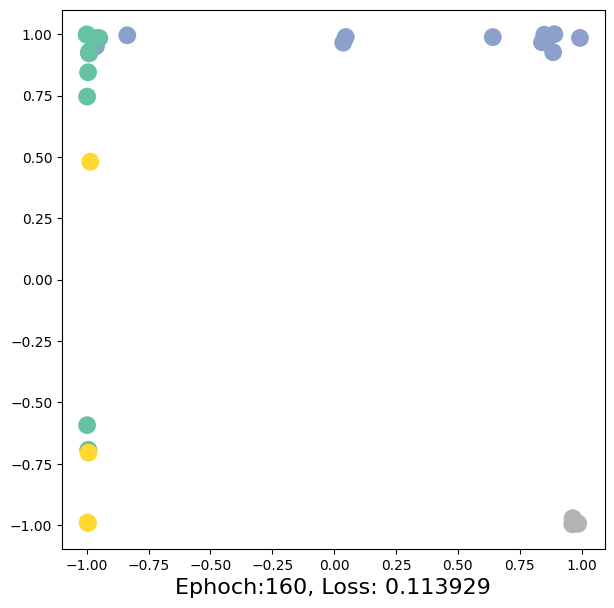

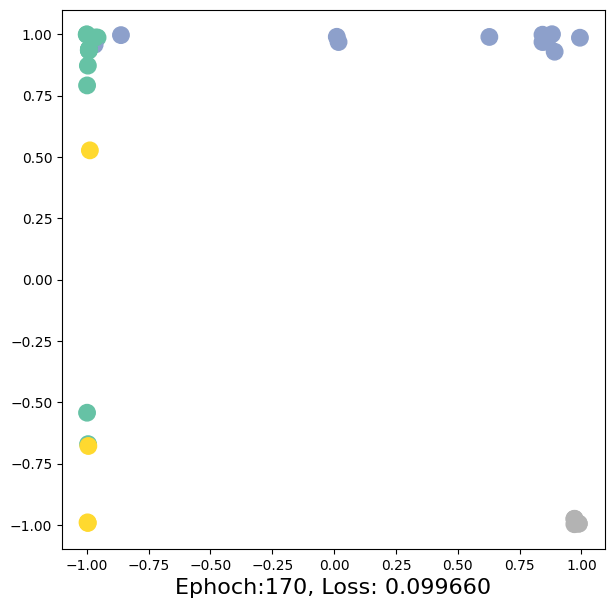

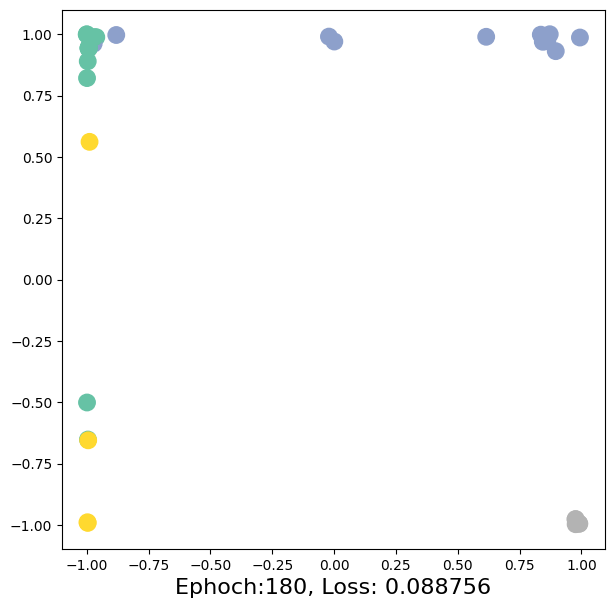

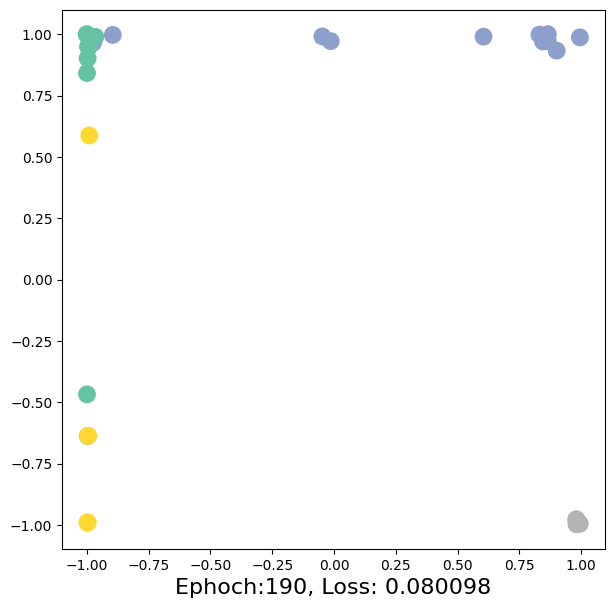

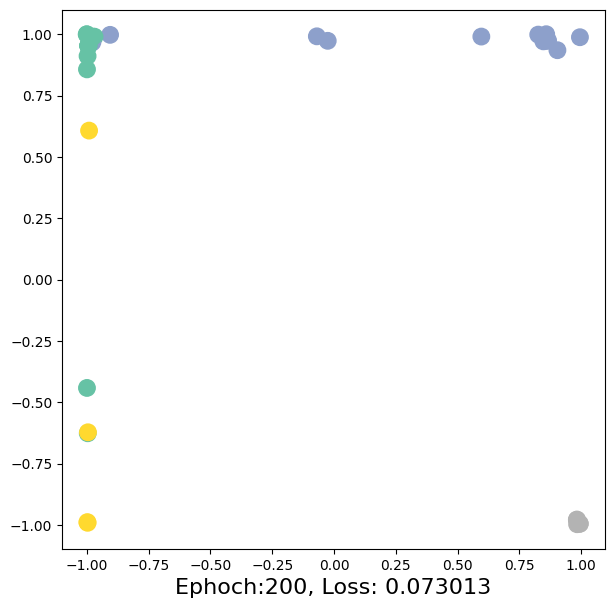

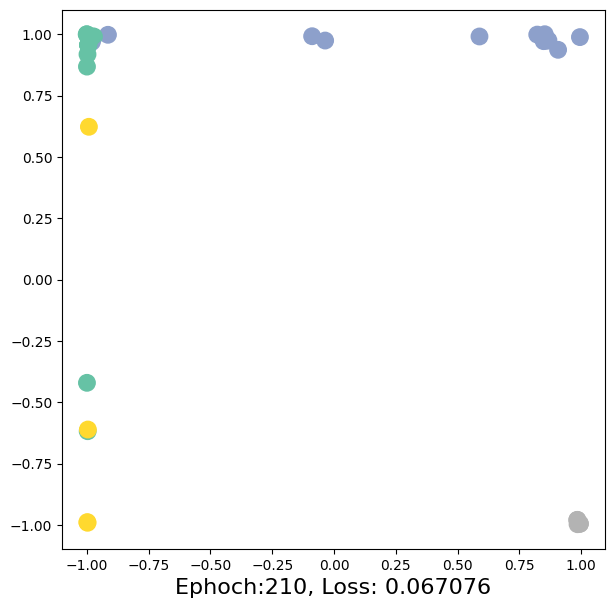

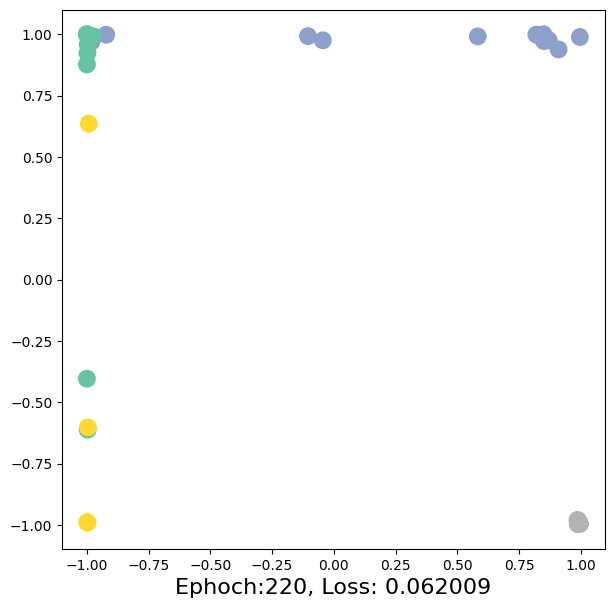

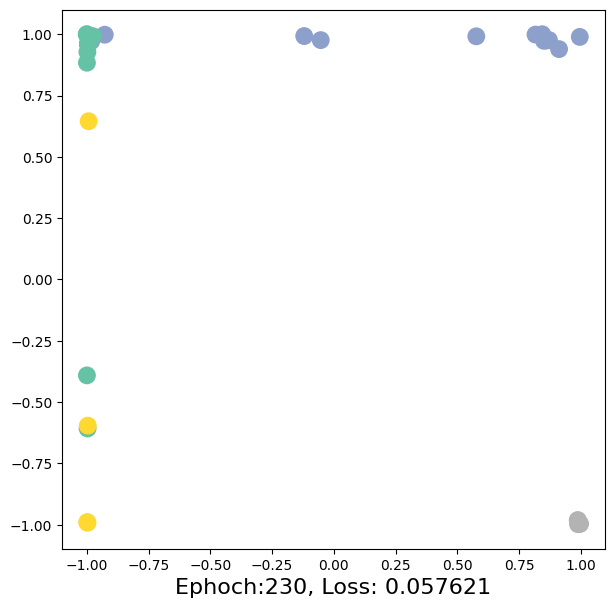

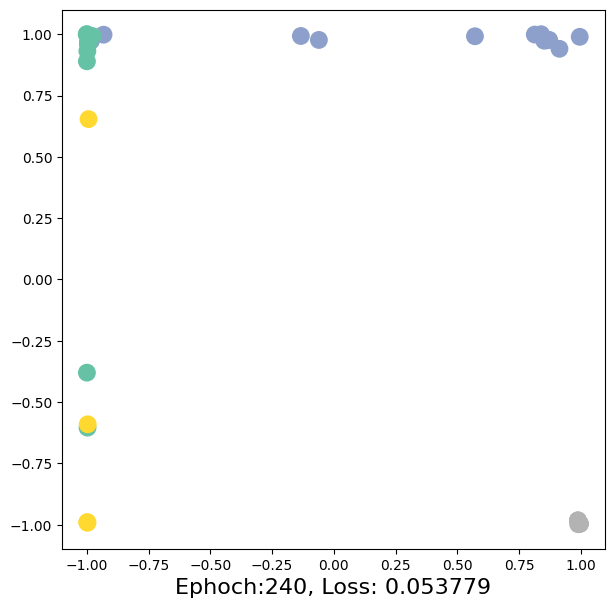

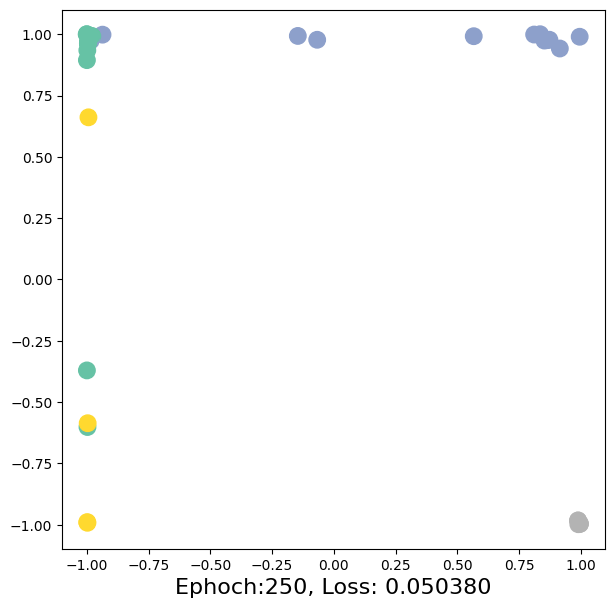

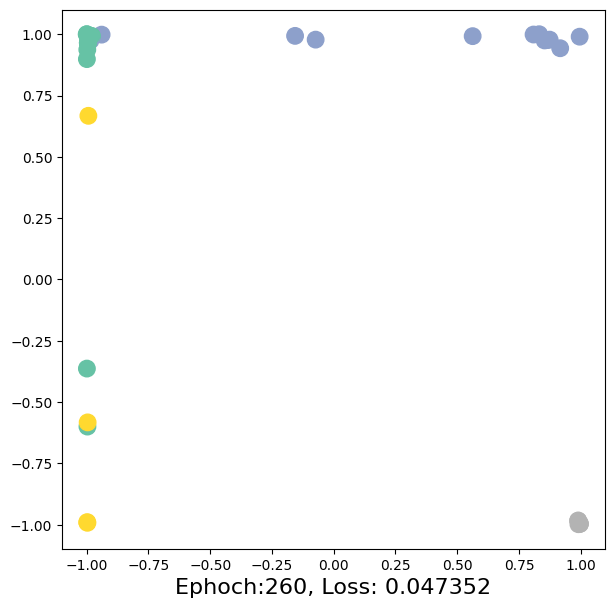

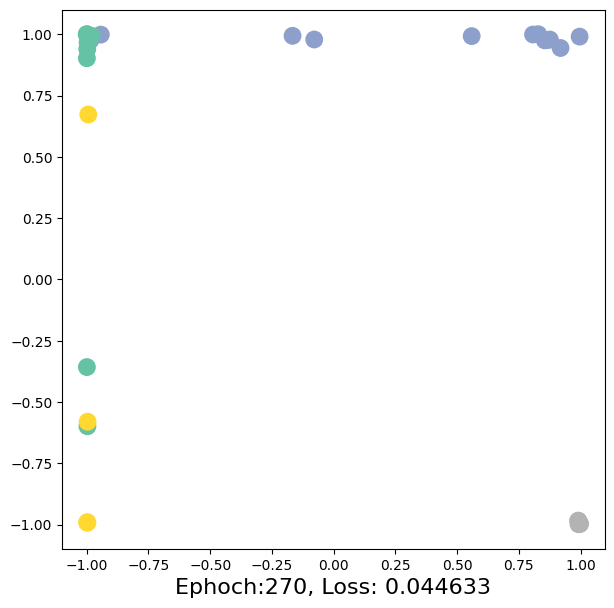

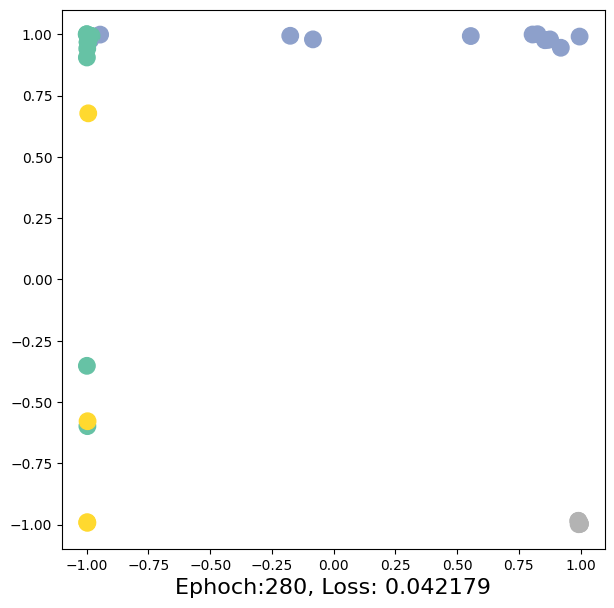

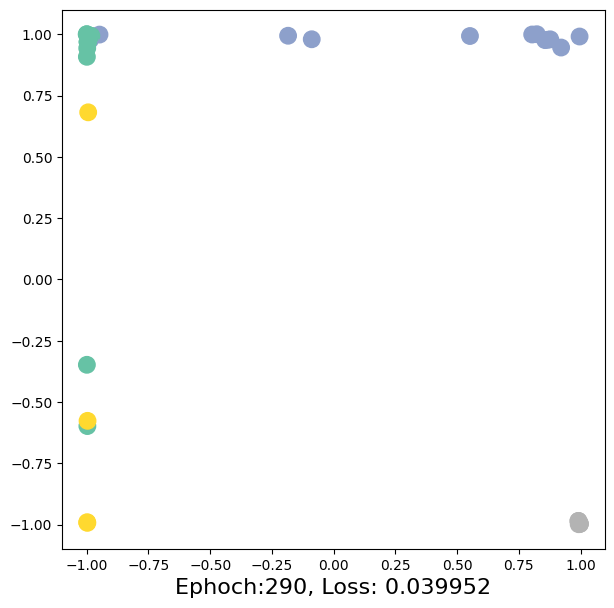

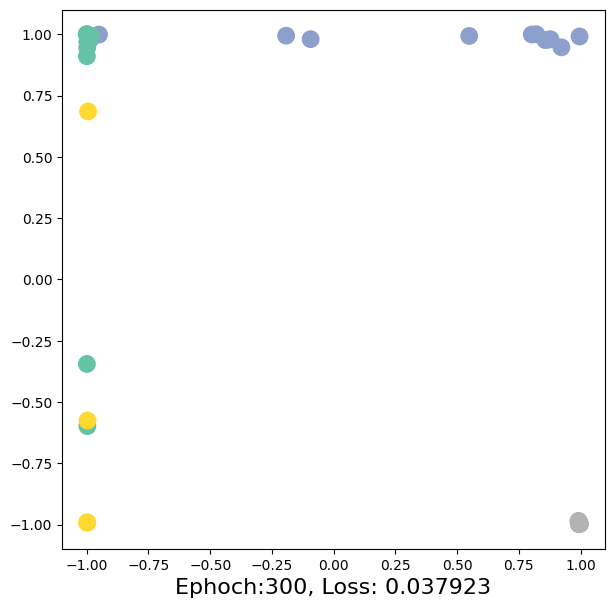

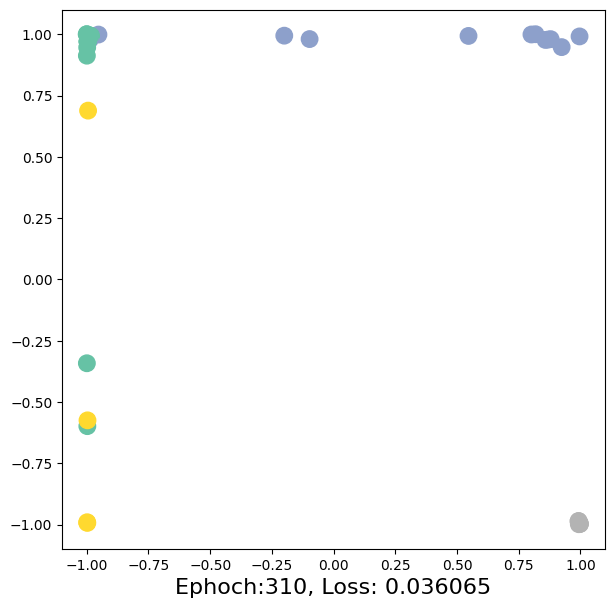

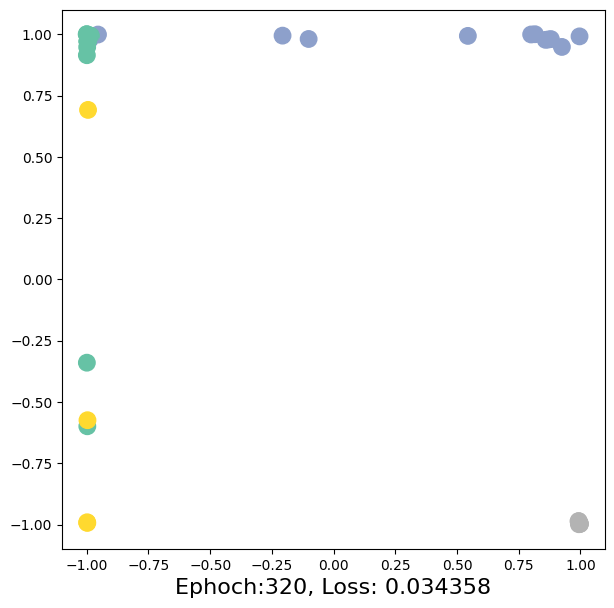

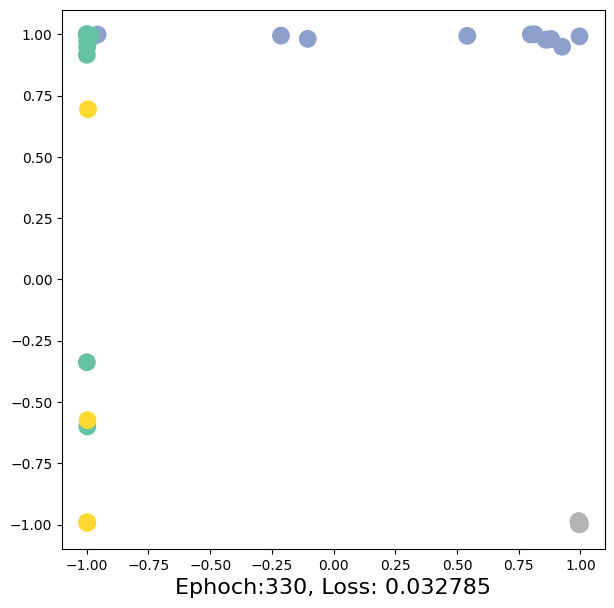

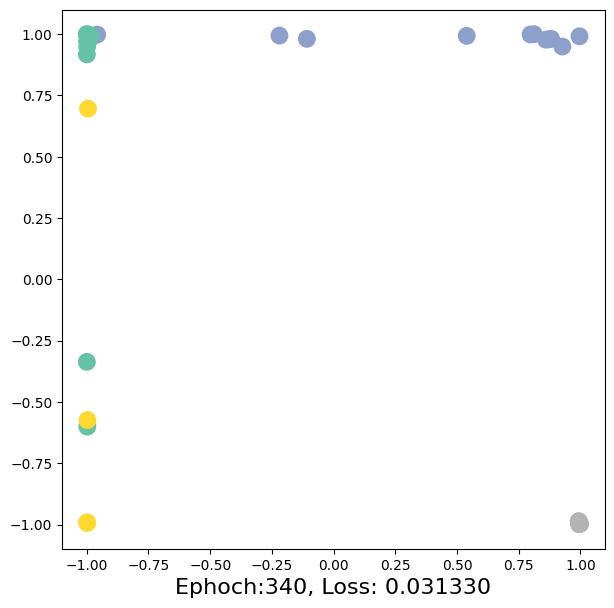

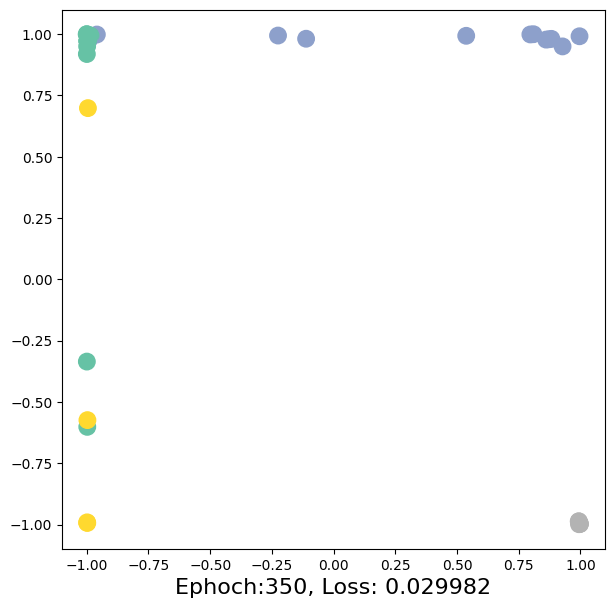

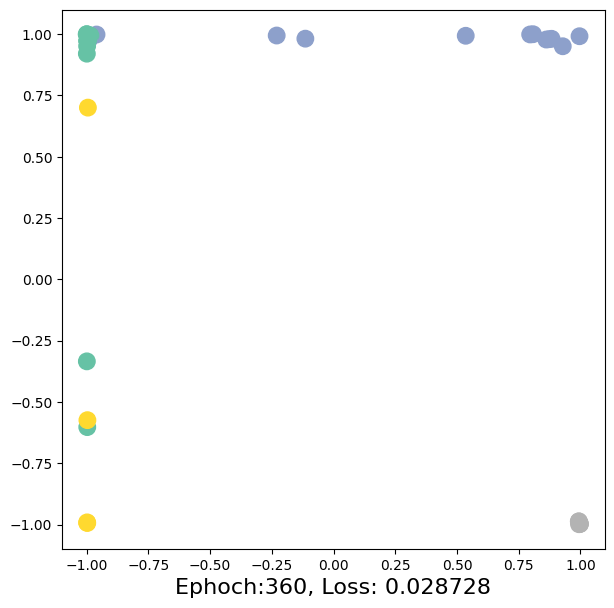

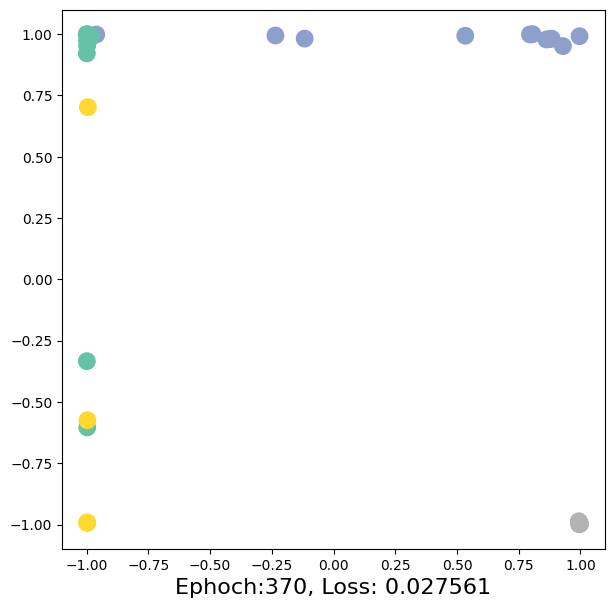

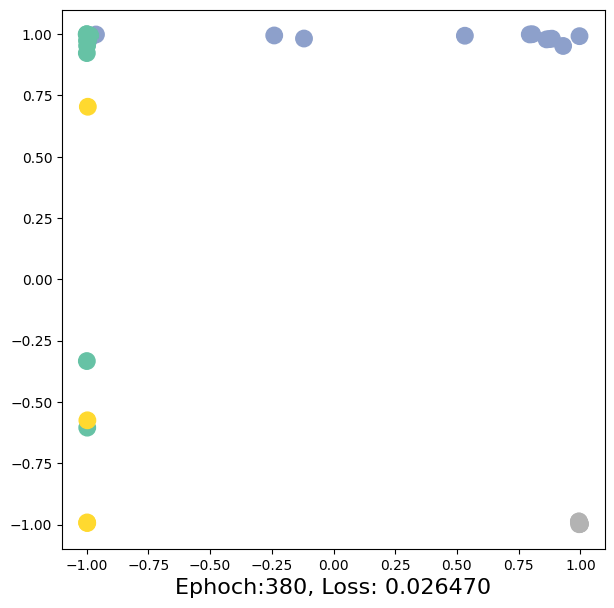

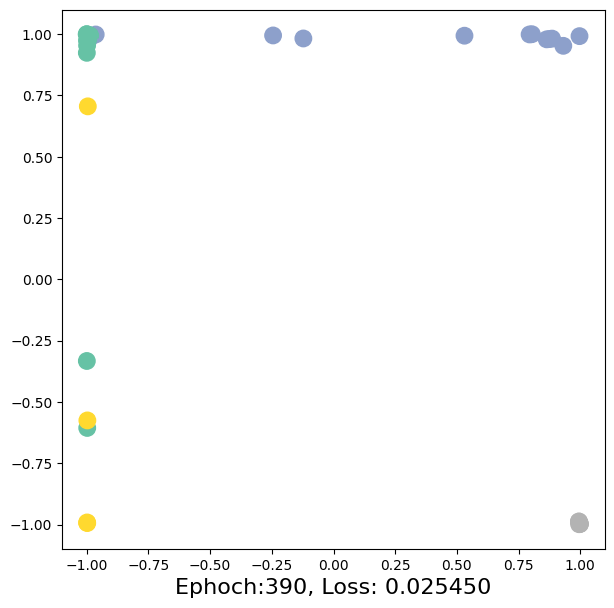

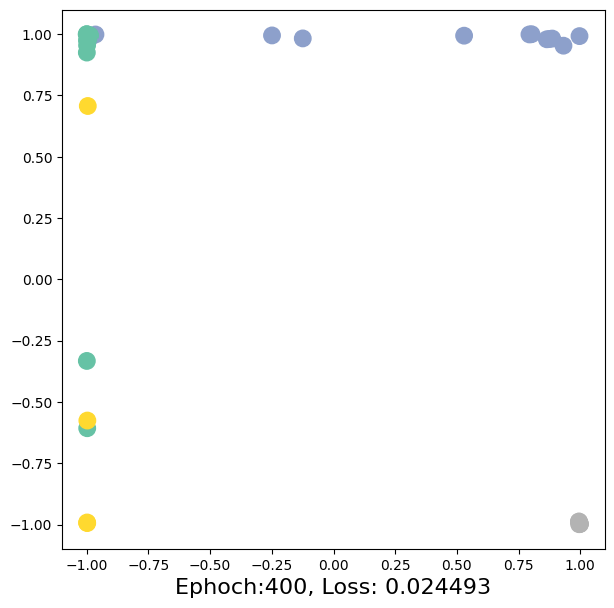

In [42]:
import time
from tqdm.auto import tqdm
loss_fn= torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

def train(data):
  out, h = model (data.x, data.edge_index)
  loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss, h
EPOCHS = 401
for epoch in tqdm(range(EPOCHS)):
  loss, h =train(data)
  if epoch % 10 == 0:
    visualize_embedding(h, color = data.y, epoch =epoch, loss= loss)
    time.sleep(0.3)